## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [2]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [3]:
import segmentation_models_pytorch as smp

In [4]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [5]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    backbone = 'se_resnext50_32x4d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 32 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 200 # 30

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 # / warmup_factor

    # ============== fold =============
    valid_id = 1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42
    
    # ==================== SWA ====================
    
    swa_start = 20
    swa_freq = 1
    swa_lr = 0.05

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'./{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.1), max_height=int(size * 0.1), 
                        mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


## helper

In [6]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [7]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [8]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [9]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [10]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [11]:
def read_image_mask(fragment_id):
    
    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [12]:
# def read_image_mask(fragment_id):
    
#     images = []
    
    
#     # take CFG.in_chans random idxs
#     idxs = np.random.choice(range(65), CFG.in_chans, replace=False)

#     for i in tqdm(idxs):
        
#         img_path = CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif"
#         print(img_path)
        
#         image = cv2.imread(img_path, 0)

#         pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
#         pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

#         image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

#         images.append(image)
#     images = np.stack(images, axis=2)

#     mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
#     mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

#     mask = mask.astype('float32')
#     mask /= 255.0
    
#     return images, mask

In [13]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [14]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [15]:
valid_xyxys = np.stack(valid_xyxys)

## dataset

In [16]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [17]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']


        return image, label

In [18]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [19]:
train_dataset[0][0].shape

torch.Size([6, 224, 224])

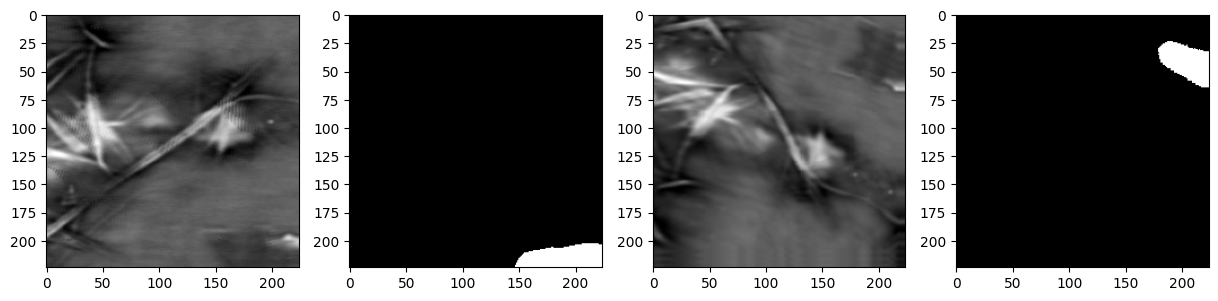

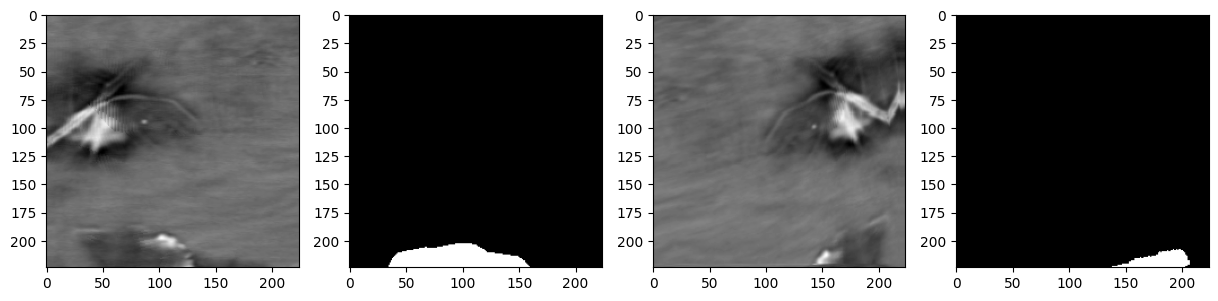

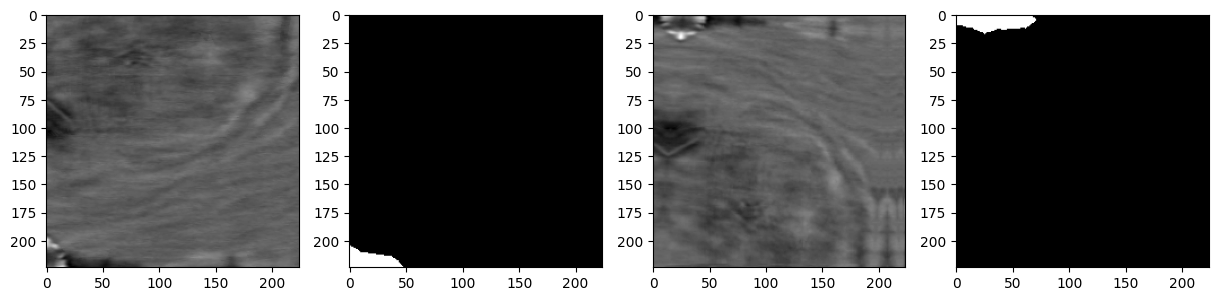

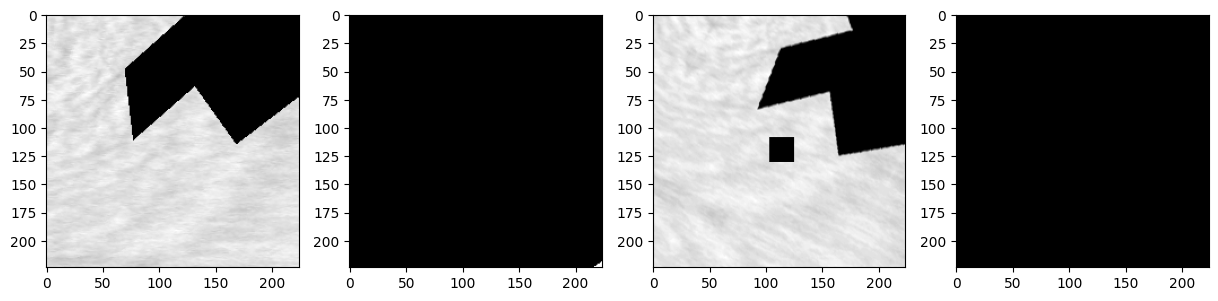

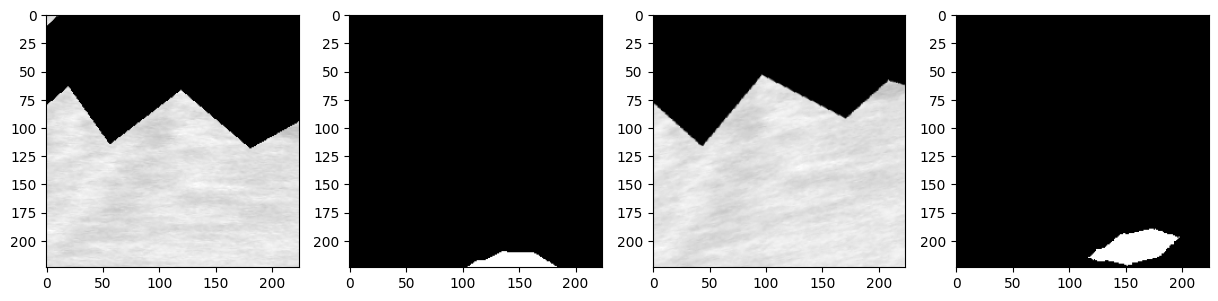

In [20]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [21]:
del plot_dataset
gc.collect()

53786

## model

In [22]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

## scheduler

In [23]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [24]:
model = build_model(CFG)
model.to(device);

# optimizer = AdamW(model.parameters(), lr=CFG.lr)
# scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext50_32x4d


## loss

In [25]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    bce_loss =  BCELoss(y_pred, y_true)
    return bce_loss
    
    y_preds_probas = torch.sigmoid(y_pred)
    dxx = torch.pow(torch.roll(y_preds_probas, shifts=-1, dims=-1) - 2*y_preds_probas + torch.roll(y_preds_probas, shifts=1, dims=-2), 2)
    dyy = torch.pow(torch.roll(y_preds_probas, shifts=-1, dims=-2) - 2*y_preds_probas + torch.roll(y_preds_probas, shifts=1, dims=-2), 2)

    # Average over all pixels
    kin_energy = torch.mean(dxx + dyy)

    
    return bce_loss + kin_energy
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [26]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg





def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [27]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 100+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [28]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [29]:
optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr)

In [30]:
# custom implementation of torch.optim.swa_utils.update_bn(train_loader, swa_model)
def manual_update_bn(model):
    model.train()
    with torch.no_grad():  # deactivate autograd engine to reduce memory usage and speed up computations

        for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
            images = images.to(device)
            _ = model(images)

In [31]:
import copy

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
    best_score_swa = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1
    best_score_swa = -1

best_loss = np.inf

swa_n = 0
for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)
    if epoch > CFG.swa_start:
        avg_val_loss_swa, mask_pred_swa = valid_fn(valid_loader, swa_model, criterion, device, valid_xyxys, valid_mask_gt)

    # scheduler_step(scheduler, avg_val_loss, epoch)

    # get best dice and threshold for both models
    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)
    if epoch > CFG.swa_start:
        best_dice_swa, best_th_swa = calc_cv(valid_mask_gt, mask_pred_swa)

    # score = avg_val_loss
    score = best_dice
    if epoch > CFG.swa_start:
        score_swa = best_dice_swa

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    if epoch > CFG.swa_start:
        Logger.info(
            f'Epoch {epoch+1} - SWA avg_val_loss: {avg_val_loss_swa:.4f}  time: {elapsed:.0f}s')

    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')
    if epoch > CFG.swa_start:
        Logger.info(
            f'Epoch {epoch+1} - SWA avgScore: {score_swa:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
        if epoch > CFG.swa_start:
            update_best_swa = score_swa < best_score_swa
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score
        if epoch > CFG.swa_start:
            update_best_swa = score_swa > best_score_swa

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

    if epoch > CFG.swa_start and update_best_swa:
        best_loss_swa = avg_val_loss_swa
        best_score_swa = score_swa

        Logger.info(
            f'Epoch {epoch+1} - Save Best SWA Score: {best_score_swa:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best SWA Loss: {best_loss_swa:.4f} Model')
        
        torch.save({'model': swa_model.state_dict(),
                    'preds': mask_pred_swa},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_swa_best.pth')
        
    # update SWA after a certain number of epochs
    if epoch >= CFG.swa_start and epoch % CFG.swa_freq == 0:
        
        if epoch == CFG.swa_start:
            # duplicate model to swa_model
            swa_model = build_model(CFG).to(device)
            swa_n = 0  # to track the number of models used for averaging
            
            # copy weights from model
            swa_model.load_state_dict(model.state_dict())
            
            # switch to SGD optimizer 
            optimizer = torch.optim.SGD(model.parameters(), lr=CFG.swa_lr)
            
            
        else:
            # loop over each parameter and update the swa_model parameter as average
            swa_n += 1
            for swa_param, param in zip(swa_model.parameters(), model.parameters()):
                swa_param.data.mul_(swa_n).add_(param.data).div_(swa_n + 1)
            
        



  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2703554494817046
th: 0.15, fbeta: 0.30783751613664734
th: 0.2, fbeta: 0.3451376085765712
th: 0.25, fbeta: 0.3868070336892838
th: 0.3, fbeta: 0.42713105709125593
th: 0.35, fbeta: 0.4625464262492205
th: 0.4, fbeta: 0.4792676260587397
th: 0.45, fbeta: 0.47504101906227986
th: 0.5, fbeta: 0.4502596467764907
th: 0.55, fbeta: 0.4001699937533986
th: 0.6, fbeta: 0.3280166632071455
th: 0.65, fbeta: 0.24000638859202691
th: 0.7, fbeta: 0.15167773067284113
th: 0.75, fbeta: 0.06450090790808297
th: 0.8, fbeta: 0.009486427393143409
th: 0.85, fbeta: 3.745604831163612e-06
th: 0.9, fbeta: 0.0
th: 0.95, fbeta: 0.0


best_th: 0.4, fbeta: 0.4792676260587397
Epoch 1 - avg_train_loss: 0.3644  avg_val_loss: 0.2511  time: 38s
Epoch 1 - avgScore: 0.4793
Epoch 1 - Save Best Score: 0.4793 Model
Epoch 1 - Save Best Loss: 0.2511 Model


th: 1.0, fbeta: 0.0
model_name Unet
backbone se_resnext50_32x4d


  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

mask_count_min: 1.0


  0%|          | 0/66 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.294151303476194
th: 0.15, fbeta: 0.3341070008686926
th: 0.2, fbeta: 0.3718307342202927
th: 0.25, fbeta: 0.407461127665835
th: 0.3, fbeta: 0.4381378768170399
th: 0.35, fbeta: 0.4628264080050281
th: 0.4, fbeta: 0.4796855739652988
th: 0.45, fbeta: 0.4848136981952429
th: 0.5, fbeta: 0.4775556714089442
th: 0.55, fbeta: 0.45006097044061355
th: 0.6, fbeta: 0.40244987756944456
th: 0.65, fbeta: 0.33306931751491764
th: 0.7, fbeta: 0.2301499917309713
th: 0.75, fbeta: 0.11070896814577923
th: 0.8, fbeta: 0.015087053270769415
th: 0.85, fbeta: 4.494577650584813e-05
th: 0.9, fbeta: 0.0
th: 0.95, fbeta: 0.0


best_th: 0.45, fbeta: 0.4848136981952429


th: 1.0, fbeta: 0.0
th: 0.1, fbeta: 0.2703554494817046
th: 0.15, fbeta: 0.30783751613664734
th: 0.2, fbeta: 0.3451376085765712
th: 0.25, fbeta: 0.3868070336892838
th: 0.3, fbeta: 0.42713105709125593
th: 0.35, fbeta: 0.4625464262492205
th: 0.4, fbeta: 0.4792676260587397
th: 0.45, fbeta: 0.47504101906227986
th: 0.5, fbeta: 0.4502596467764907
th: 0.55, fbeta: 0.4001699937533986
th: 0.6, fbeta: 0.3280166632071455
th: 0.65, fbeta: 0.24000638859202691
th: 0.7, fbeta: 0.15167773067284113
th: 0.75, fbeta: 0.06450090790808297
th: 0.8, fbeta: 0.009486427393143409
th: 0.85, fbeta: 3.745604831163612e-06
th: 0.9, fbeta: 0.0
th: 0.95, fbeta: 0.0


best_th: 0.4, fbeta: 0.4792676260587397
Epoch 2 - avg_train_loss: 0.2590  avg_val_loss: 0.2432  time: 45s
Epoch 2 - SWA avg_val_loss: 0.2511  time: 45s
Epoch 2 - avgScore: 0.4848
Epoch 2 - SWA avgScore: 0.4793
Epoch 2 - Save Best Score: 0.4848 Model
Epoch 2 - Save Best Loss: 0.2432 Model


th: 1.0, fbeta: 0.0


Epoch 2 - Save Best SWA Score: 0.4793 Model
Epoch 2 - Save Best SWA Loss: 0.2511 Model


  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

mask_count_min: 1.0


  0%|          | 0/66 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.30329086996321575
th: 0.15, fbeta: 0.343023343223734
th: 0.2, fbeta: 0.3798249810726094
th: 0.25, fbeta: 0.41418251357515357
th: 0.3, fbeta: 0.44251927855511664
th: 0.35, fbeta: 0.4666191415143411
th: 0.4, fbeta: 0.4817519896895862
th: 0.45, fbeta: 0.4889381006050939
th: 0.5, fbeta: 0.4828374663643859
th: 0.55, fbeta: 0.4629960404878627
th: 0.6, fbeta: 0.42050374823566816
th: 0.65, fbeta: 0.3586888953484135
th: 0.7, fbeta: 0.27158391905019724
th: 0.75, fbeta: 0.15673003328675222
th: 0.8, fbeta: 0.04394131252299327
th: 0.85, fbeta: 0.0009057815407594099
th: 0.9, fbeta: 0.0
th: 0.95, fbeta: 0.0


best_th: 0.45, fbeta: 0.4889381006050939


th: 1.0, fbeta: 0.0
th: 0.1, fbeta: 0.2752739691562419
th: 0.15, fbeta: 0.30978802393099586
th: 0.2, fbeta: 0.34407185247558353
th: 0.25, fbeta: 0.3823907132840732
th: 0.3, fbeta: 0.41974820517308736
th: 0.35, fbeta: 0.4541173549775834
th: 0.4, fbeta: 0.47466784000123874
th: 0.45, fbeta: 0.477636607408632
th: 0.5, fbeta: 0.46568829649094257
th: 0.55, fbeta: 0.42971962734468766
th: 0.6, fbeta: 0.3743484595700546
th: 0.65, fbeta: 0.2932612720731119
th: 0.7, fbeta: 0.19895313850246507
th: 0.75, fbeta: 0.10406492918758477
th: 0.8, fbeta: 0.025064960970491882
th: 0.85, fbeta: 0.00014512577099130107
th: 0.9, fbeta: 0.0
th: 0.95, fbeta: 0.0


best_th: 0.45, fbeta: 0.477636607408632
Epoch 3 - avg_train_loss: 0.2538  avg_val_loss: 0.2391  time: 45s
Epoch 3 - SWA avg_val_loss: 0.2479  time: 45s
Epoch 3 - avgScore: 0.4889
Epoch 3 - SWA avgScore: 0.4776
Epoch 3 - Save Best Score: 0.4889 Model
Epoch 3 - Save Best Loss: 0.2391 Model


th: 1.0, fbeta: 0.0


  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

mask_count_min: 1.0


  0%|          | 0/66 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2971382392082531
th: 0.15, fbeta: 0.33282721978249813
th: 0.2, fbeta: 0.36523578079676117
th: 0.25, fbeta: 0.3973581395500779
th: 0.3, fbeta: 0.42615117112658896
th: 0.35, fbeta: 0.4484232128196631
th: 0.4, fbeta: 0.47078459914662346
th: 0.45, fbeta: 0.4822507702671016
th: 0.5, fbeta: 0.4868854410309659
th: 0.55, fbeta: 0.48070896043218625
th: 0.6, fbeta: 0.4630632661238445
th: 0.65, fbeta: 0.4229243548547441
th: 0.7, fbeta: 0.3579606617503757
th: 0.75, fbeta: 0.2511766214062268
th: 0.8, fbeta: 0.11247801726819791
th: 0.85, fbeta: 0.010463203816491191
th: 0.9, fbeta: 1.2173133629777816e-05
th: 0.95, fbeta: 0.0


best_th: 0.5, fbeta: 0.4868854410309659


th: 1.0, fbeta: 0.0
th: 0.1, fbeta: 0.27678243744591535
th: 0.15, fbeta: 0.30888594939508524
th: 0.2, fbeta: 0.34083667103259024
th: 0.25, fbeta: 0.37658128799691304
th: 0.3, fbeta: 0.41223786278618485
th: 0.35, fbeta: 0.44525629231765557
th: 0.4, fbeta: 0.46875877603460603
th: 0.45, fbeta: 0.47502575500309585
th: 0.5, fbeta: 0.47215247681846256
th: 0.55, fbeta: 0.44904176750360386
th: 0.6, fbeta: 0.4038370544105471
th: 0.65, fbeta: 0.33936334072742874
th: 0.7, fbeta: 0.2446213200007086
th: 0.75, fbeta: 0.14407234244630263
th: 0.8, fbeta: 0.04826630136233818
th: 0.85, fbeta: 0.0016804312304626648
th: 0.9, fbeta: 0.0
th: 0.95, fbeta: 0.0


best_th: 0.45, fbeta: 0.47502575500309585
Epoch 4 - avg_train_loss: 0.2525  avg_val_loss: 0.2397  time: 44s
Epoch 4 - SWA avg_val_loss: 0.2468  time: 44s
Epoch 4 - avgScore: 0.4869
Epoch 4 - SWA avgScore: 0.4750


th: 1.0, fbeta: 0.0


  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

mask_count_min: 1.0


  0%|          | 0/66 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.29994361102899525
th: 0.15, fbeta: 0.3365407087901513
th: 0.2, fbeta: 0.3707706352122601
th: 0.25, fbeta: 0.40441124659262145
th: 0.3, fbeta: 0.43362525933367196
th: 0.35, fbeta: 0.45608666803178227
th: 0.4, fbeta: 0.47618675580607045
th: 0.45, fbeta: 0.48552771073202267
th: 0.5, fbeta: 0.48877759571869905
th: 0.55, fbeta: 0.4801719541483997
th: 0.6, fbeta: 0.4552864017854537
th: 0.65, fbeta: 0.4118260736273428
th: 0.7, fbeta: 0.34517071779868935
th: 0.75, fbeta: 0.2487882216835654
th: 0.8, fbeta: 0.1245706097077757
th: 0.85, fbeta: 0.022819429367795296
th: 0.9, fbeta: 5.9926983750637465e-05
th: 0.95, fbeta: 0.0


best_th: 0.5, fbeta: 0.48877759571869905


th: 1.0, fbeta: 0.0
th: 0.1, fbeta: 0.2778397699624023
th: 0.15, fbeta: 0.3086968064715064
th: 0.2, fbeta: 0.33923436798294215
th: 0.25, fbeta: 0.37372839535145697
th: 0.3, fbeta: 0.40838088641359555
th: 0.35, fbeta: 0.4394530931519643
th: 0.4, fbeta: 0.463271097316738
th: 0.45, fbeta: 0.47259888488001284
th: 0.5, fbeta: 0.4725596116919671
th: 0.55, fbeta: 0.45981457715941104
th: 0.6, fbeta: 0.4233437173615558
th: 0.65, fbeta: 0.3678864798342878
th: 0.7, fbeta: 0.28429381420062666
th: 0.75, fbeta: 0.1748950783470137
th: 0.8, fbeta: 0.07114582803970461
th: 0.85, fbeta: 0.006708521751293318
th: 0.9, fbeta: 0.0
th: 0.95, fbeta: 0.0


best_th: 0.45, fbeta: 0.47259888488001284
Epoch 5 - avg_train_loss: 0.2504  avg_val_loss: 0.2379  time: 45s
Epoch 5 - SWA avg_val_loss: 0.2463  time: 45s
Epoch 5 - avgScore: 0.4888
Epoch 5 - SWA avgScore: 0.4726


th: 1.0, fbeta: 0.0


  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

mask_count_min: 1.0


  0%|          | 0/66 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2956872977870273
th: 0.15, fbeta: 0.32493001053941317
th: 0.2, fbeta: 0.3521695646957647
th: 0.25, fbeta: 0.3796971623393198
th: 0.3, fbeta: 0.40577715912235623
th: 0.35, fbeta: 0.42459882602645066
th: 0.4, fbeta: 0.44207593339308116
th: 0.45, fbeta: 0.45606165671973353
th: 0.5, fbeta: 0.4643619918809591
th: 0.55, fbeta: 0.4669439355239705
th: 0.6, fbeta: 0.46448443997951505
th: 0.65, fbeta: 0.45114500009046415
th: 0.7, fbeta: 0.4214739834937986
th: 0.75, fbeta: 0.36202576483035537
th: 0.8, fbeta: 0.2503857516500587
th: 0.85, fbeta: 0.10557789628614704
th: 0.9, fbeta: 0.007772327610182304
th: 0.95, fbeta: 0.0


best_th: 0.55, fbeta: 0.4669439355239705


th: 1.0, fbeta: 0.0
th: 0.1, fbeta: 0.2786984597602871
th: 0.15, fbeta: 0.30866233576032936
th: 0.2, fbeta: 0.33831533019983523
th: 0.25, fbeta: 0.37183581697132223
th: 0.3, fbeta: 0.4056388728956431
th: 0.35, fbeta: 0.4344168738942628
th: 0.4, fbeta: 0.45857146658215125
th: 0.45, fbeta: 0.470061482180674
th: 0.5, fbeta: 0.47133224615973973
th: 0.55, fbeta: 0.4645016969885106
th: 0.6, fbeta: 0.4364291287695904
th: 0.65, fbeta: 0.3868620726724005
th: 0.7, fbeta: 0.31396497704079207
th: 0.75, fbeta: 0.20160943067241835
th: 0.8, fbeta: 0.09386175282817705
th: 0.85, fbeta: 0.012932613941979318
th: 0.9, fbeta: 1.8728052213098475e-06
th: 0.95, fbeta: 0.0


best_th: 0.5, fbeta: 0.47133224615973973
Epoch 6 - avg_train_loss: 0.2492  avg_val_loss: 0.2491  time: 44s
Epoch 6 - SWA avg_val_loss: 0.2460  time: 44s
Epoch 6 - avgScore: 0.4669
Epoch 6 - SWA avgScore: 0.4713


th: 1.0, fbeta: 0.0


  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

mask_count_min: 1.0


  0%|          | 0/66 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.30130421086125925
th: 0.15, fbeta: 0.33267070253951114
th: 0.2, fbeta: 0.3619746998553676
th: 0.25, fbeta: 0.3913934089580385
th: 0.3, fbeta: 0.4180699824884927
th: 0.35, fbeta: 0.4353383613768766
th: 0.4, fbeta: 0.4537789510952432
th: 0.45, fbeta: 0.4676516055612864
th: 0.5, fbeta: 0.47363802394989624
th: 0.55, fbeta: 0.47470725342580833
th: 0.6, fbeta: 0.46392402325096826
th: 0.65, fbeta: 0.4363317690357083
th: 0.7, fbeta: 0.38969354197896994
th: 0.75, fbeta: 0.3073856482951316
th: 0.8, fbeta: 0.1906647361426546
th: 0.85, fbeta: 0.06133625711656937
th: 0.9, fbeta: 0.0017103382089304518
th: 0.95, fbeta: 0.0


best_th: 0.55, fbeta: 0.47470725342580833


th: 1.0, fbeta: 0.0
th: 0.1, fbeta: 0.2788705446980418
th: 0.15, fbeta: 0.307974522726068
th: 0.2, fbeta: 0.3367901287265894
th: 0.25, fbeta: 0.36938084613663397
th: 0.3, fbeta: 0.40255573491890956
th: 0.35, fbeta: 0.42969636093742786
th: 0.4, fbeta: 0.45378983904034853
th: 0.45, fbeta: 0.46618461518481186
th: 0.5, fbeta: 0.46936177992116485
th: 0.55, fbeta: 0.4648409565558373
th: 0.6, fbeta: 0.44425811637910995
th: 0.65, fbeta: 0.40090572159225635
th: 0.7, fbeta: 0.33415370407685474
th: 0.75, fbeta: 0.22536063316383576
th: 0.8, fbeta: 0.11322858974934011
th: 0.85, fbeta: 0.020007373042448998
th: 0.9, fbeta: 3.464598820815996e-05
th: 0.95, fbeta: 0.0


best_th: 0.5, fbeta: 0.46936177992116485
Epoch 7 - avg_train_loss: 0.2479  avg_val_loss: 0.2421  time: 45s
Epoch 7 - SWA avg_val_loss: 0.2461  time: 45s
Epoch 7 - avgScore: 0.4747
Epoch 7 - SWA avgScore: 0.4694


th: 1.0, fbeta: 0.0


  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

mask_count_min: 1.0


  0%|          | 0/66 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.30820342337919787
th: 0.15, fbeta: 0.3420604552950814
th: 0.2, fbeta: 0.37529848541091326
th: 0.25, fbeta: 0.4085508906992098
th: 0.3, fbeta: 0.43306345420726383
th: 0.35, fbeta: 0.452821281525694
th: 0.4, fbeta: 0.47040883623455987
th: 0.45, fbeta: 0.480073120594711
th: 0.5, fbeta: 0.4824937939233282
th: 0.55, fbeta: 0.47356466753483806
th: 0.6, fbeta: 0.4492857196691925
th: 0.65, fbeta: 0.4153902804194983
th: 0.7, fbeta: 0.3558450534126891
th: 0.75, fbeta: 0.2686363984339832
th: 0.8, fbeta: 0.1543204057687897
th: 0.85, fbeta: 0.04773696964270327
th: 0.9, fbeta: 0.0009815165051210697
th: 0.95, fbeta: 0.0


best_th: 0.5, fbeta: 0.4824937939233282


th: 1.0, fbeta: 0.0
th: 0.1, fbeta: 0.2790419225209112
th: 0.15, fbeta: 0.3075255780337613
th: 0.2, fbeta: 0.3356689437774389
th: 0.25, fbeta: 0.36732389899858847
th: 0.3, fbeta: 0.39981453073200407
th: 0.35, fbeta: 0.42575641088610683
th: 0.4, fbeta: 0.44972685894990716
th: 0.45, fbeta: 0.46249196944656695
th: 0.5, fbeta: 0.46763035679906845
th: 0.55, fbeta: 0.464433980347055
th: 0.6, fbeta: 0.44977137890197616
th: 0.65, fbeta: 0.411617676128462
th: 0.7, fbeta: 0.34882913122884573
th: 0.75, fbeta: 0.24603344073381367
th: 0.8, fbeta: 0.12811770900313915
th: 0.85, fbeta: 0.02682334233458642
th: 0.9, fbeta: 0.00011048590705672293
th: 0.95, fbeta: 0.0


best_th: 0.5, fbeta: 0.46763035679906845
Epoch 8 - avg_train_loss: 0.2467  avg_val_loss: 0.2382  time: 45s
Epoch 8 - SWA avg_val_loss: 0.2464  time: 45s
Epoch 8 - avgScore: 0.4825
Epoch 8 - SWA avgScore: 0.4676


th: 1.0, fbeta: 0.0


  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

mask_count_min: 1.0


  0%|          | 0/66 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.30758421304666933
th: 0.15, fbeta: 0.33756045004710034
th: 0.2, fbeta: 0.36561378854392745
th: 0.25, fbeta: 0.3927579715866671
th: 0.3, fbeta: 0.41628682845364506
th: 0.35, fbeta: 0.4324106169884167
th: 0.4, fbeta: 0.4462336266913383
th: 0.45, fbeta: 0.4605577338367572
th: 0.5, fbeta: 0.47039681823106483
th: 0.55, fbeta: 0.47507128569718776
th: 0.6, fbeta: 0.47244960437045425
th: 0.65, fbeta: 0.4637102278382381
th: 0.7, fbeta: 0.4388552577430157
th: 0.75, fbeta: 0.39554459116162677
th: 0.8, fbeta: 0.30556069019819737
th: 0.85, fbeta: 0.172844195619877
th: 0.9, fbeta: 0.032762879101742165
th: 0.95, fbeta: 8.427579304204547e-06


best_th: 0.55, fbeta: 0.47507128569718776


th: 1.0, fbeta: 0.0
th: 0.1, fbeta: 0.2791845384529054
th: 0.15, fbeta: 0.30712978273830727
th: 0.2, fbeta: 0.3347680439994175
th: 0.25, fbeta: 0.36565708879436354
th: 0.3, fbeta: 0.39747531146260023
th: 0.35, fbeta: 0.4226992971129507
th: 0.4, fbeta: 0.44646877638857013
th: 0.45, fbeta: 0.4593453538012105
th: 0.5, fbeta: 0.46581105432733205
th: 0.55, fbeta: 0.46438364266316584
th: 0.6, fbeta: 0.4533190840984088
th: 0.65, fbeta: 0.42084525797241457
th: 0.7, fbeta: 0.361721458899074
th: 0.75, fbeta: 0.2650027413597415
th: 0.8, fbeta: 0.14235745459271323
th: 0.85, fbeta: 0.03438790257975765
th: 0.9, fbeta: 0.0003164244368445158
th: 0.95, fbeta: 0.0


best_th: 0.5, fbeta: 0.46581105432733205
Epoch 9 - avg_train_loss: 0.2426  avg_val_loss: 0.2482  time: 45s
Epoch 9 - SWA avg_val_loss: 0.2467  time: 45s
Epoch 9 - avgScore: 0.4751
Epoch 9 - SWA avgScore: 0.4658


th: 1.0, fbeta: 0.0


  0%|          | 0/451 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:

# Update batch normalization for the SWA model before saving and/or evaluation
manual_update_bn(swa_model)       


# Finally, save the SWA model
torch.save({'model': swa_model.state_dict()},
            CFG.model_dir + f'{CFG.model_name}_fold{fold}_swa.pth')

In [ ]:
# mask_pred = check_point['preds']

In [ ]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred_swa)

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred_swa)
axes[2].imshow((mask_pred_swa>=best_th).astype(int))

In [ ]:
plt.hist(mask_pred_swa.flatten(), bins=20)